# Objective and Data

<font size=4>Objective:</font> <br>
   Let's first start with a question. <br>
   We want to find if getting a job depends on what stream you are choosing? <br>
  ~In other words, <br>
   What is the causal relationship between "PlacedOrNot" (outcome) and "Stream" (treatment)? <br>

<font size=4>Dataset:</font> <br>
https://www.kaggle.com/datasets/tejashvi14/engineering-placements-prediction

In [1]:
import pandas as pd
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from dowhy import gcm, CausalModel
import numpy as np
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from econml.sklearn_extensions.model_selection import GridSearchCVList
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import clone
from econml.sklearn_extensions.linear_model import WeightedLasso
from econml.dml import CausalForestDML

In [2]:
df = pd.read_csv('/Users/jaydeepchakraborty/JC/git-projects/model_util/DataSets/Clg_Placement/CollegePlacement.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966 entries, 0 to 2965
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Age                2966 non-null   int64 
 1   Gender             2966 non-null   object
 2   Stream             2966 non-null   object
 3   Internships        2966 non-null   int64 
 4   CGPA               2966 non-null   int64 
 5   Hostel             2966 non-null   int64 
 6   HistoryOfBacklogs  2966 non-null   int64 
 7   PlacedOrNot        2966 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 185.5+ KB


In [4]:
df.head(3)

,Age,Gender,Stream,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
0,22,Male,Electronics And Communication,1,8,1,1,1
1,21,Female,Computer Science,0,7,1,1,1
2,22,Female,Information Technology,1,6,0,0,1


In [5]:
'''
converting the Stream into numeric category
'''
unk_stream = df['Stream'].unique()
le_stream = LabelEncoder()
df['Stream'] = le_stream.fit_transform(df['Stream'].astype(str))
unk_stream_id = df['Stream'].unique()
print(unk_stream)
print(unk_stream_id)
print(list(le_stream.inverse_transform(unk_stream_id)))

['Electronics And Communication' 'Computer Science'
 'Information Technology' 'Mechanical' 'Electrical' 'Civil']
[3 1 4 5 2 0]
['Electronics And Communication', 'Computer Science', 'Information Technology', 'Mechanical', 'Electrical', 'Civil']


In [6]:
'''
converting the Gender into numeric category
'''
unk_gender = df['Gender'].unique()
le_gender = LabelEncoder()
df['Gender'] = le_gender.fit_transform(df['Gender'].astype(str))
unk_gender_id = df['Gender'].unique()
print(unk_gender)
print(unk_gender_id)
print(list(le_gender.inverse_transform(unk_gender_id)))

['Male' 'Female']
[1 0]
['Male', 'Female']


In [7]:
df.head(3)

,Age,Gender,Stream,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
0,22,1,3,1,8,1,1,1
1,21,0,1,0,7,1,1,1
2,22,0,4,1,6,0,0,1


For any causal analysis, we mainly focus on the below variables <br>
1) Outcome <br>
Here, Target is "PlacedOrNot". It is binary. We have single outcome. <br>
2) Treatment <br>
Here, Treatment is "Hostel". It is binary. We have single treatment. <br>
3) Confounders <br>
The variables which has effect on both Treatment and Outcome. <br>
4) Instrumental variables <br>
The variables which has effect on only Treatment <br>

let's do some <b>visualization</b> to understand the relation between the variables.

<AxesSubplot:xlabel='PlacedOrNot', ylabel='count'>

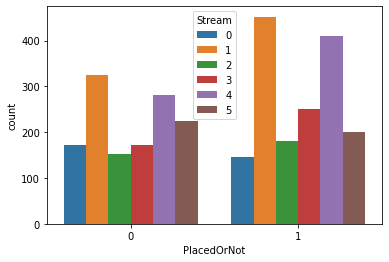

In [8]:
sns.countplot(
    data=df, x="PlacedOrNot", hue="Stream"
)

# DoWhy

## STEP_1: Modeling

There are two ways this step can be done. <br>
1) Provide a causal graph in either gml or dot format. Can be a text file or a string. <br>
2) Instead of the graph, provide variable names that correspond to relevant categories, <br>
such as common causes, instrumental variables etc. <br>
<br>
According to dowhy documentation providing causal graph is recommended.

### STEP_1.a: Modeling with causal graph

This assumtions are mainly derived by or influenced by domain knowledge. <br>
1) From the features list down all the assumtions.  <br>
2) From the assumtions generate the causal graph.  <br>
To create a causal graph dagitty [http://dagitty.net/dags.html#] tool will help. [not needed , follow syntax]  <br>
Variables are encoded as nodes and relationships between them as directed edges. Direction of the edges denotes the direction of the causal influence.

--> <b>Assumptions</b> <br>
First create a link from "Stream" (Treatment) to "PlacedOrNot" (Outcome). <br> 
1) "Internships" directly effects "PlacedOrNot".
2) "CGPA" directly effects "PlacedOrNot".
3) "Stream" will effect both "Internships" and "CGPA".
4) "HistoryOfBacklogs" will effect "CGPA" and "Internships".
5) "Hostel" will effect on "CGPA"
6) "Age" will effect "HistoryOfBacklogs" and "Internships".
7) "Gender" will effect on "Stream"

In [21]:
causal_graph = """digraph{
Age[label="age"];
Gender[label="gender"];
Stream[label="stream"];
Internships[label="internship"];
CGPA[label="CGPA"];
Hostel[label="hostel"];
HistoryOfBacklogs[label="backlogs"];
PlacedOrNot[label="palced?"];
Stream->PlacedOrNot;
Internships->PlacedOrNot;
CGPA->PlacedOrNot;
Stream->Internships;
Stream->CGPA;
HistoryOfBacklogs->CGPA;
HistoryOfBacklogs->Internships;
Hostel->CGPA;
Age->HistoryOfBacklogs;
Age->Internships;
Gender->Stream;
}"""

In [25]:
model=CausalModel(
        data = df,
        treatment=["Stream"],
        outcome=["PlacedOrNot"],
        graph=causal_graph.replace("\n"," ")
        )

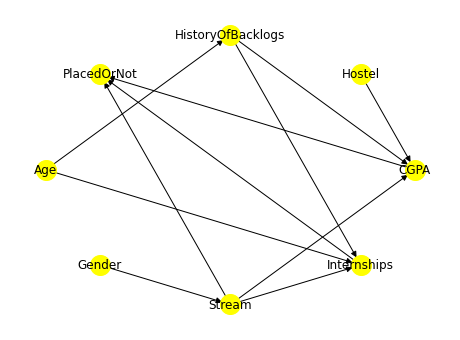

In [26]:
model.view_model(layout="dot")

### STEP_1.b: Modeling with variables

In [ ]:
# '''
# Confounders (common_causes): These are variables that cause both the action and the outcome. As a result, any observed correlation between 
# the action and the outcome may simply be due to the confounder variables, and not due to any causal relationship from the action to the outcome.

# Instrumental Variables (instruments): These are special variables that cause the action, but do not directly affect the outcome. 
# In addition, they are not affected by any variable that affects the outcome. Instrumental variables can help reduce bias, if used in the correct way.

# effect_modifiers: names of variables that can modify the treatment effect. 

# '''
# model=CausalModel(
#         data = df,
#         treatment=["Stream"],
#         outcome=["PlacedOrNot"],
#         common_causes=['Gender', "HistoryOfBacklogs", "Internships", "CGPA", "Hostel"],
#         instruments=None,
#         effect_modifiers=None,
#         )

In [ ]:
# model.view_model(layout="dot")
# # from IPython.display import Image, display
# # display(Image(filename="causal_model.png"))

## STEP_2: Identification

--> In this step, <br>
Given a causal graph and a target quantity (e.g., effect of T on Y), the process of identifcation is to check whether <br>
the target quantity can be estimated given the observed variables. <br>

In [61]:
'''
If there is a warning asks you if there are any unobserved confounders that are missing in this dataset. If there are, 
then ignoring them will lead to an incorrect estimate. If you want to disable the warning, 
you can use proceed_when_unidentifiable=True as an additional parameter to identify_effect

DoWhy model automatically identifies the causal effect i.e. the Treatment affecting the Outcome if changing the Treatment 
affects the Outcome when everything else is still the saame/constant.

Estimand: Parameter in the population which is to be estimated in a statistical analysis
Estimator: A rule for calculating an estimate of a given quantity based on observed data
Estimation: The process of finding an estimate

There are three different methods to identify causal effects from a graph.
1) Back-door criterion (derived from a more general set of identification rules called do-calculus that has been formulated by Judea Pearl and colleagues (e.g. Pearl, 2009).)
--> requires that there are no hidden/unobserved confounders in our data. This assumption might be difficult to meet in some of the real-world scenarios.

UC should not be in the causal graph.
UC --> T
UC --> Y

2) Front-door criterion (derived from a more general set of identification rules called do-calculus that has been formulated by Judea Pearl and colleagues (e.g. Pearl, 2009).)
--> Front-door criterion allows for hidden confounding between the treatment and the outcome.
--> It requires variable that which mediates the influence from treatment to outcome but that variable should not be influenced by hidden/unobserved confounders.

T --> Z
Z --> Y
UC --> T
UC --> Y
UC --> Z (this should not be in causal graph)

3) Instrumental variables (IV) (developed by Philip Wright)
--> IV allows for hidden confounding between the treatment and the outcome.
--> It requires instrumental variables which affects T but does not affect Y.

T --> Y
UC --> T
UC --> Y
Z --> X
Z --> Y (this should not be in causal graph)


***
DoWhy is that it will identify causal effects in the graph automatically (assuming that they are identifiable using one of the three methods we discussed above.
identify_effect() variable produces "estimand". It denotes the quantity that we want to estimate.
One can think of causal estimands as adjusted formulas that only contain the variables that we want to control for in order to obtain unbiased causal estimates.
Estimand is not a value nor a method of estimation, it’s a quantity to be estimated.

'''
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True, method_name='exhaustive-search')
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                    
─────────(E[PlacedOrNot])
d[Stream]                
Estimand assumption 1, Unconfoundedness: If U→{Stream} and U→PlacedOrNot then P(PlacedOrNot|Stream,,U) = P(PlacedOrNot|Stream,)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d                  ⎛    d              ⎞  ⎥
E⎢─────────(PlacedOrNot)⋅⎜─────────([Stream])⎟  ⎥
 ⎣d[Gender]              ⎝d[Gender]          ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→PlacedOrNot then ¬(U →→{Gender})
Estimand assumption 2, Exclusion: If we remove {Gender}→{Stream}, then ¬({Gender}→PlacedOrNot)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



<font size=3>Explanation:</font> <br>
This estimation is highly dependent on what causal graph (assumptions) we have provided to the model. <br>
This is basically a recipe that gives us our desired causal effect.  <br>
In other words, it tells us how to compute the effect of "Stream" (Treatment) on "PlacedOrNot" (Outcome). <br>

## STEP_3: Estimation

In [ ]:
'''

The estimation step involves building a statistical estimator that can compute the target estimand identified in the previous step.

--> DoWhy use different methods for estimating the causal effect of a (pre-specified)treatment variable on a (pre-specified) outcome variable.
[https://github.com/py-why/dowhy/blob/main/docs/source/example_notebooks/dowhy_estimation_methods.ipynb
https://www.pywhy.org/dowhy/v0.9.1/_modules/dowhy/causal_model.html#CausalModel.estimate_effect] 

--> 
The control group receives either no treatment, a standard treatment whose effect is already known, or a placebo (a fake treatment to control for placebo effect).
The treatment group (also called the experimental group) receives the treatment whose effect the researcher is interested in. 

ATE = Average Treatment Effect
ATT = Average Treatment Effect on Treated (i.e. those who were assigned to different stream)
ATC = Average Treatment Effect on Control (i.e. those who were assigned to different stream)

-->
Depending on the dataset properties, different estimation methods can be used
[All these estmation methods can be called through DoWhy and EconML library]

'''

#### STEP_3.a: Estimation using "linear regression"

In [50]:
estimate_linear_regression = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.linear_regression",
                                target_units="ate")
print(estimate_linear_regression)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['HistoryOfBacklogs', 'Hostel', 'Age']}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                    
─────────(E[PlacedOrNot])
d[Stream]                
Estimand assumption 1, Unconfoundedness: If U→{Stream} and U→PlacedOrNot then P(PlacedOrNot|Stream,,U) = P(PlacedOrNot|Stream,)

## Realized estimand
b: PlacedOrNot~Stream+Stream*HistoryOfBacklogs+Stream*Hostel+Stream*Age
Target units: ate

## Estimate
Mean value: 0.00657070905318724
### Conditional Estimates
__categorical__HistoryOfBacklogs  __categorical__Hostel  __categorical__Age
(-0.001, 1.0]                     (-0.001, 1.0]          (18.999, 21.0]        0.003773
                                                         (21.0, 22

<font size=3>Explanation</font>:- <br>
The average causal effect is about 0.0065. This can be interpreted as, having a change in stream changes your probability of placement by +0.65%. 

In [40]:
estimate_instrumental_variable = model.estimate_effect(identified_estimand, 
                                 method_name="iv.instrumental_variable")
print(estimate_instrumental_variable)

instrumental_variable
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d                  ⎛    d              ⎞  ⎥
E⎢─────────(PlacedOrNot)⋅⎜─────────([Stream])⎟  ⎥
 ⎣d[Gender]              ⎝d[Gender]          ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→PlacedOrNot then ¬(U →→{Gender})
Estimand assumption 2, Exclusion: If we remove {Gender}→{Stream}, then ¬({Gender}→PlacedOrNot)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
 ⎡   d                ⎤  -1⎡   d           ⎤
E⎢───────(PlacedOrNot)⎥⋅E  ⎢───────(Stream)⎥
 ⎣dGender             ⎦    ⎣dGender        ⎦
Estimand assumption 1, As-if-random: If U→→PlacedOrNot then ¬(U →→{Gender})
Estimand assumption 2, Exclusion: If we remove {Gender}→{Stream}, then ¬({Gender}→PlacedOrNot)
Estimand assumption 3, treatment_effect_homo

<font size=3>Explanation</font>:- <br>
The average causal effect is about -0.1661. This can be interpreted as, having a change in stream changes your probability of placement by -16.61%. 

## STEP_4: Refutation

In [ ]:
'''
--> Remember that the Causal part does not come from data, rather it comes from your assumptions (Step-1) that were used to identify(Step-2) and estimate(Step-3) the cause.
--> Thus it becomes verify our assumptions and challenge their validity in more than one way if possible.
--> DoWhy offers Multiple Robustness Checks that can be used to test the validity of our assumptions.

Refutation methods provide tests that every correct estimator should pass. So if an estimator fails the refutation test (p-value is <0.05), 
then it means that there is some problem with the estimator.
'''

#### STEP_4.a: Refutation using "Random Common Cause"

In [ ]:
'''
Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. 
If our assumption was originally correct then there shouldn’t much variation in the causal estimate.
'''

In [42]:
refutation = model.refute_estimate(identified_estimand, 
                                   estimate_linear_regression, 
                                   method_name="random_common_cause")
print(refutation)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['HistoryOfBacklogs', 'Hostel', 'Age']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['HistoryOfBacklogs', 'Hostel', 'Age']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['HistoryOfBacklogs', 'Hostel', 'Age']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['HistoryOfBacklogs', 'Hostel', 'Age']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_in

In [43]:
refutation = model.refute_estimate(identified_estimand, 
                                   estimate_instrumental_variable, 
                                   method_name="random_common_cause")
print(refutation)

Refute: Add a random common cause
Estimated effect:-0.16611300743630367
New effect:-0.16611300743630372
p value:2.0



<font size=3>Explanation</font>:- <br>
Here the Estimated effect and New affect are almost same. So our assumtion is correct.

#### STEP_4.b: Refutation using "Placebo Treatment Refuter"

In [ ]:
'''
Randomly assigns any covariate as a treatment and re-runs the analysis. 
If our assumptions were correct then this newly found out estimate should go to 0.
'''

In [55]:
refutation = model.refute_estimate(identified_estimand, 
                                   estimate_linear_regression, 
                                   method_name="placebo_treatment_refuter")
print(refutation)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['HistoryOfBacklogs', 'Hostel', 'Age']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['HistoryOfBacklogs', 'Hostel', 'Age']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['HistoryOfBacklogs', 'Hostel', 'Age']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['HistoryOfBacklogs', 'Hostel', 'Age']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_in

In [54]:
refutation = model.refute_estimate(identified_estimand, 
                                   estimate_instrumental_variable, 
                                   method_name="placebo_treatment_refuter",
                                   placebo_type="permute", 
                                   num_simulations=20)
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:-0.16611300743630367
New effect:-0.07940281178637078
p value:0.40332041191446577



<font size=3>Explanation</font>:- <br>
Here the New affect is almost zero. So our assumtion is correct.

#### STEP_4.c: Refutation using "Data Subset Refuter"

In [ ]:
'''
Creates subsets of the data(similar to cross-validation) and checks whether the causal estimates vary across subsets. 
If our assumptions were correct there shouldn’t be much variation.
'''

In [58]:
refutation = model.refute_estimate(identified_estimand, 
                                   estimate_linear_regression, 
                                   method_name="data_subset_refuter")
print(refutation)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['HistoryOfBacklogs', 'Hostel', 'Age']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['HistoryOfBacklogs', 'Hostel', 'Age']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['HistoryOfBacklogs', 'Hostel', 'Age']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['HistoryOfBacklogs', 'Hostel', 'Age']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_in

In [60]:
refutation = model.refute_estimate(identified_estimand, 
                                   estimate_instrumental_variable, 
                                   method_name="data_subset_refuter")
print(refutation)

Refute: Use a subset of data
Estimated effect:-0.16611300743630367
New effect:-0.039881262838866796
p value:0.98



<font size=3>Explanation</font>:- <br>
Here the Estimated effect and New affect are almost same. So our assumtion is correct.

But in "estimate_instrumental_variable", we can see there is difference between "Estimated effect" and "New effect".
SO, our assumption is questionable.

<font size=4>Final Decision</font> <br>
Based on the refutal method, <br>
We could agree that change in "Stream" causes whether the student will job or not.

# DoWhy and EconML

## STEP_1: Modeling

There are two ways this step can be done. <br>
1) Provide a causal graph in either gml or dot format. Can be a text file or a string. <br>
2) Instead of the graph, provide variable names that correspond to relevant categories, <br>
such as common causes, instrumental variables etc. <br>
<br>
According to dowhy documentation providing causal graph is recommended.

### STEP_1.a: Modeling with causal graph

This assumtions are mainly derived by or influenced by domain knowledge. <br>
1) From the features list down all the assumtions.  <br>
2) From the assumtions generate the causal graph.  <br>
To create a causal graph dagitty [http://dagitty.net/dags.html#] tool will help. [not needed , follow syntax]  <br>
Variables are encoded as nodes and relationships between them as directed edges. Direction of the edges denotes the direction of the causal influence.

--> <b>Assumptions</b> <br>
First create a link from "Stream" (Treatment) to "PlacedOrNot" (Outcome). <br> 
1) "Internships" directly effects "PlacedOrNot".
2) "CGPA" directly effects "PlacedOrNot".
3) "Stream" will effect both "Internships" and "CGPA".
4) "HistoryOfBacklogs" will effect "CGPA" and "Internships".
5) "Hostel" will effect on "CGPA"
6) "Age" will effect "HistoryOfBacklogs" and "Internships".
7) "Gender" will effect on "Stream"

In [15]:
causal_graph = """digraph{
Age[label="age"];
Gender[label="gender"];
Stream[label="stream"];
Internships[label="internship"];
CGPA[label="CGPA"];
Hostel[label="hostel"];
HistoryOfBacklogs[label="backlogs"];
PlacedOrNot[label="palced?"];
Stream->PlacedOrNot;
Internships->PlacedOrNot;
CGPA->PlacedOrNot;
Stream->Internships;
Stream->CGPA;
HistoryOfBacklogs->CGPA;
HistoryOfBacklogs->Internships;
Hostel->CGPA;
Age->HistoryOfBacklogs;
Age->Internships;
Gender->Stream;
}"""

In [16]:
model=CausalModel(
        data = df,
        treatment=["Stream"],
        outcome=["PlacedOrNot"],
        graph=causal_graph.replace("\n"," ")
        )

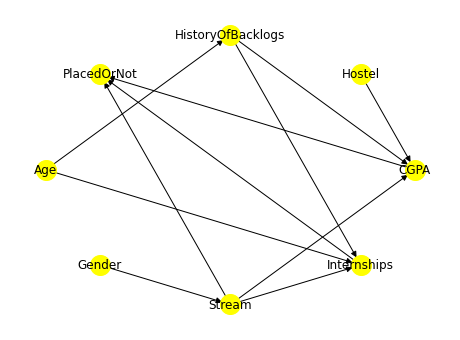

In [17]:
model.view_model(layout="dot")

### STEP_1.b: Modeling with variables

In [ ]:
# '''
# Confounders (common_causes): These are variables that cause both the action and the outcome. As a result, any observed correlation between 
# the action and the outcome may simply be due to the confounder variables, and not due to any causal relationship from the action to the outcome.

# Instrumental Variables (instruments): These are special variables that cause the Treatment, but do not directly affect the Outcome. 
# In addition, they are not affected by any variable that affects the outcome. Instrumental variables can help reduce bias, if used in the correct way.

# effect_modifiers: names of variables that can modify the treatment effect. 

# '''
# model=CausalModel(
#         data = df,
#         treatment=["Stream"],
#         outcome=["PlacedOrNot"],
#         common_causes=['Gender', "HistoryOfBacklogs", "Internships", "CGPA", "Hostel"],
#         instruments=None,
#         effect_modifiers=None,
#         )

In [ ]:
# model.view_model(layout="dot")
# # from IPython.display import Image, display
# # display(Image(filename="causal_model.png"))

## STEP_2: Identification

--> In this step, <br>
Given a causal graph and a target quantity (e.g., effect of T on Y), the process of identifcation is to check whether <br>
the target quantity can be estimated given the observed variables. <br>

In [18]:
'''
If there is a warning asks you if there are any unobserved confounders that are missing in this dataset. If there are, 
then ignoring them will lead to an incorrect estimate. If you want to disable the warning, 
you can use proceed_when_unidentifiable=True as an additional parameter to identify_effect

DoWhy model automatically identifies the causal effect i.e. the Treatment affecting the Outcome if changing the Treatment 
affects the Outcome when everything else is still the saame/constant.

Estimand: Parameter in the population which is to be estimated in a statistical analysis
Estimator: A rule for calculating an estimate of a given quantity based on observed data
Estimation: The process of finding an estimate

There are three different methods to identify causal effects from a graph.
1) Back-door criterion (derived from a more general set of identification rules called do-calculus that has been formulated by Judea Pearl and colleagues (e.g. Pearl, 2009).)
--> requires that there are no hidden/unobserved confounders in our data. This assumption might be difficult to meet in some of the real-world scenarios.

UC should not be in the causal graph.
UC --> T
UC --> Y

2) Front-door criterion (derived from a more general set of identification rules called do-calculus that has been formulated by Judea Pearl and colleagues (e.g. Pearl, 2009).)
--> Front-door criterion allows for hidden confounding between the treatment and the outcome.
--> It requires variable that which mediates the influence from treatment to outcome but that variable should not be influenced by hidden/unobserved confounders.

T --> Z
Z --> Y
UC --> T
UC --> Y
UC --> Z (this should not be in causal graph)

3) Instrumental variables (IV) (developed by Philip Wright)
--> IV allows for hidden confounding between the treatment and the outcome.
--> It requires instrumental variables which affects T but does not affect Y.

T --> Y
UC --> T
UC --> Y
Z --> X
Z --> Y (this should not be in causal graph)


***
DoWhy is that it will identify causal effects in the graph automatically (assuming that they are identifiable using one of the three methods we discussed above.
identify_effect() variable produces "estimand". It denotes the quantity that we want to estimate.
One can think of causal estimands as adjusted formulas that only contain the variables that we want to control for in order to obtain unbiased causal estimates.
Estimand is not a value nor a method of estimation, it’s a quantity to be estimated.

'''
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True, method_name='exhaustive-search')
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                    
─────────(E[PlacedOrNot])
d[Stream]                
Estimand assumption 1, Unconfoundedness: If U→{Stream} and U→PlacedOrNot then P(PlacedOrNot|Stream,,U) = P(PlacedOrNot|Stream,)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d                  ⎛    d              ⎞  ⎥
E⎢─────────(PlacedOrNot)⋅⎜─────────([Stream])⎟  ⎥
 ⎣d[Gender]              ⎝d[Gender]          ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→PlacedOrNot then ¬(U →→{Gender})
Estimand assumption 2, Exclusion: If we remove {Gender}→{Stream}, then ¬({Gender}→PlacedOrNot)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## STEP_3: Estimation

In [ ]:
'''

The estimation step involves building a statistical estimator that can compute the target estimand identified in the previous step.

--> EconML
[https://econml.azurewebsites.net/spec/comparison.html]

--> 
The control group receives either no treatment, a standard treatment whose effect is already known, or a placebo (a fake treatment to control for placebo effect).
The treatment group (also called the experimental group) receives the treatment whose effect the researcher is interested in. 

ATE = Average Treatment Effect
ATT = Average Treatment Effect on Treated (i.e. those who were assigned to different stream)
ATC = Average Treatment Effect on Control (i.e. those who were assigned to different stream)

-->
Depending on the dataset properties, different estimation methods can be used
[All these estmation methods can be called through DoWhy and EconML library]

'''


In [22]:
metalearner_estimate = model.estimate_effect(identified_estimand, 
                                             method_name="backdoor.econml.metalearners.TLearner",
                                             confidence_intervals=False,
                                             method_params={
                                                 "init_params":{'models': RandomForestRegressor()},
                                                 "fit_params":{}
                                                          }
                                            )

print(metalearner_estimate)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                    
─────────(E[PlacedOrNot])
d[Stream]                
Estimand assumption 1, Unconfoundedness: If U→{Stream} and U→PlacedOrNot then P(PlacedOrNot|Stream,,U) = P(PlacedOrNot|Stream,)

## Realized estimand
b: PlacedOrNot~Stream+HistoryOfBacklogs+Hostel+Age
Target units: ate

## Estimate
Mean value: 0.1042216170782699
Effect estimates: [0.2796564  0.36477832 0.27952837 ... 0.27952837 0.27952837 0.05700846]



## STEP_4: Refutation

In [ ]:
'''
--> Remember that the Causal part does not come from data, rather it comes from your assumptions (Step-1) that were used to identify(Step-2) and estimate(Step-3) the cause.
--> Thus it becomes verify our assumptions and challenge their validity in more than one way if possible.
--> DoWhy offers Multiple Robustness Checks that can be used to test the validity of our assumptions.

Refutation methods provide tests that every correct estimator should pass. So if an estimator fails the refutation test (p-value is <0.05), 
then it means that there is some problem with the estimator.
'''

#### STEP_4.a: Refutation using "Random Common Cause"

In [ ]:
'''
Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. 
If our assumption was originally correct then there shouldn’t much variation in the causal estimate.
'''

In [23]:
refutation = model.refute_estimate(identified_estimand, 
                                   metalearner_estimate, 
                                   method_name="random_common_cause")
print(refutation)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Refute: Add a random common cause
Estimated effect:0.1042216170782699
New effect:0.11027623061362103
p value:0.54



#### STEP_4.b: Refutation using "Placebo Treatment Refuter"

In [ ]:
'''
Randomly assigns any covariate as a treatment and re-runs the analysis. 
If our assumptions were correct then this newly found out estimate should go to 0.
'''

In [24]:
refutation = model.refute_estimate(identified_estimand, 
                                   metalearner_estimate,
                                   method_name="placebo_treatment_refuter")
print(refutation)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Refute: Use a Placebo Treatment
Estimated effect:0.1042216170782699
New effect:0.002596245934744435
p value:0.84



#### STEP_4.c: Refutation using "Data Subset Refuter"

In [ ]:
'''
Creates subsets of the data(similar to cross-validation) and checks whether the causal estimates vary across subsets. 
If our assumptions were correct there shouldn’t be much variation.
'''

In [25]:
refutation = model.refute_estimate(identified_estimand, 
                                   metalearner_estimate, 
                                   method_name="data_subset_refuter")
print(refutation)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Refute: Use a subset of data
Estimated effect:0.1042216170782699
New effect:0.11157673690119178
p value:0.8



# Finding root cause of a test observation

In [ ]:
'''
let's take two examples where students failed.
We want to know the root cause of their job placement failure based on the observed data
https://www.pywhy.org/dowhy/v0.8/example_notebooks/rca_microservice_architecture.html
'''

In [8]:
df.head(5)

,Age,Gender,Stream,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
0,22,1,3,1,8,1,1,1
1,21,0,1,0,7,1,1,1
2,22,0,4,1,6,0,0,1
3,21,1,4,0,8,0,1,1
4,22,1,5,0,8,1,0,1


In [9]:
outlier_data = pd.DataFrame({'Age': [25, 22],
                       'Gender': [0, 1],
                       'Stream': [0, 2],
                       'Internships': [0, 0],
                       'CGPA': [6, 5],
                       'Hostel': [0, 1],
                       'HistoryOfBacklogs': [2, 1],
                        'PlacedOrNot': [0, 0]
                       })
display(outlier_data)

,Age,Gender,Stream,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
0,25,0,0,0,6,0,2,0
1,22,1,2,0,5,1,1,0


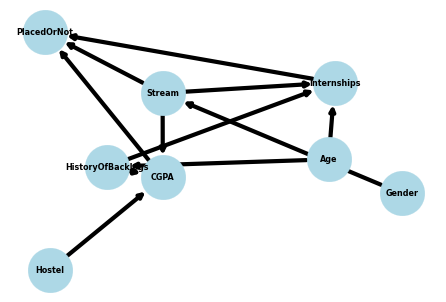

In [10]:
causal_graph = nx.DiGraph([('Gender', 'Stream'),
                           ('Stream', 'Internships'),
                           ('Stream', 'CGPA'),
                           ('Stream', 'PlacedOrNot'),
                           ('Internships', 'PlacedOrNot'),
                           ('CGPA', 'PlacedOrNot'),
                           ('Hostel', 'CGPA'),
                           ('HistoryOfBacklogs', 'CGPA'),
                           ('HistoryOfBacklogs', 'Internships'),
                           ('Age', 'HistoryOfBacklogs'),
                           ('Age', 'Internships')])

plt.rcParams['figure.figsize'] = [7, 5] # Make plot bigger
gcm.util.plot(causal_graph)

In [31]:
nx.write_gml(causal_graph, "causal_graph.gml")

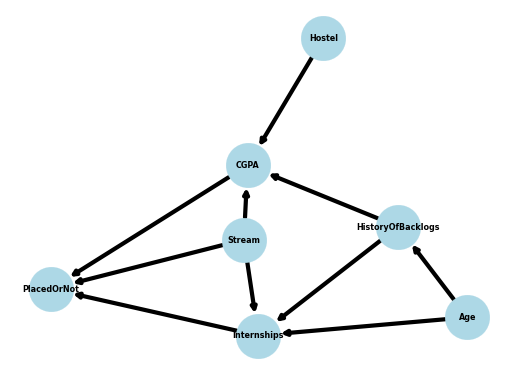

In [27]:
causal_graph_nx = nx.read_gml("causal_graph.gml")
plt.rcParams['figure.figsize'] = [7, 5] # Make plot bigger
gcm.util.plot(causal_graph_nx)

In [11]:
causal_model = gcm.StructuralCausalModel(causal_graph)

In [36]:
# from scipy.stats import halfnorm
# for node in causal_graph.nodes:
#     if len(list(causal_graph.predecessors(node))) > 0:
#         causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
#     else:
#         causal_model.set_causal_mechanism(node, gcm.ScipyDistribution(halfnorm))

In [12]:
gcm.auto.assign_causal_mechanisms(causal_model, df)

In [13]:
gcm.config.disable_progress_bars() # to disable print statements when computing Shapley values

median_attribs, uncertainty_attribs = gcm.confidence_intervals(
    gcm.bootstrap_training_and_sampling(gcm.attribute_anomalies,
                        causal_model,
                        bootstrap_training_data=df,
                        target_node='PlacedOrNot',
                        anomaly_samples=outlier_data,
                        shapley_config=gcm.shapley.ShapleyConfig(n_jobs=1)),
    num_bootstrap_resamples=1)

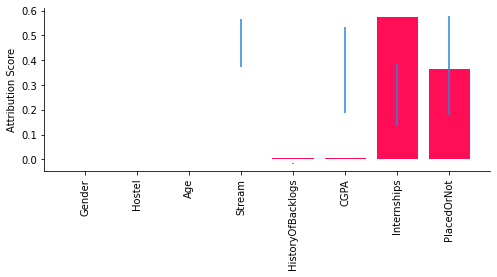

In [14]:
def bar_plot_with_uncertainty(median_attribs, uncertainty_attribs, ylabel='Attribution Score', figsize=(8, 3), bwidth=0.8, xticks=None, xticks_rotation=90):
    fig, ax = plt.subplots(figsize=figsize)
    yerr_plus = [uncertainty_attribs[node][1] - median_attribs[node] for node in median_attribs.keys()]
    yerr_minus = [median_attribs[node] - uncertainty_attribs[node][0] for node in median_attribs.keys()]
    plt.bar(median_attribs.keys(), median_attribs.values(), yerr=np.array([yerr_minus, yerr_plus]), ecolor='#1E88E5', color='#ff0d57', width=bwidth)
    plt.xticks(rotation=xticks_rotation)
    plt.ylabel(ylabel)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if xticks:
        plt.xticks(list(median_attribs.keys()), xticks)
    plt.show()

bar_plot_with_uncertainty(median_attribs, uncertainty_attribs)

# Resources
1) https://github.com/py-why/dowhy#four-steps-of-causal-inference
2) https://www.pywhy.org/dowhy/v0.9.1/example_notebooks/dowhy_simple_example.html
3) https://www.pywhy.org/dowhy/v0.9.1/example_notebooks/gcm_rca_microservice_architecture.html

In [9]:
'''
First, 
figure out the below variables 

Y = Outcome
T = Treatment
W = Controls/Confounders (W --> T, W --> Y)
Z = Instrumental Variable (Z --> T)
X = Other features
'''

outcome_col = 'PlacedOrNot'
treatment_col = 'Stream'
confounder_col = None
instrumental_var_col = None
feature_col = ['Age', 'Gender', 'Internships', 'CGPA', 'Hostel', 'HistoryOfBacklogs']

In [10]:
'''
Second,
divide the data into two sets (train, test)
'''
X = df[['Age', 'Gender', 'Internships', 'CGPA', 'Hostel', 'HistoryOfBacklogs', 'Stream']]
y = df['PlacedOrNot']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.005, random_state=42)

In [11]:
'''
Third,
populate Y, T, W, Z, X - for estimator input
'''

Y_train_data = y_train.copy()
T_train_data = X_train['Stream'].copy()
W_train_data = None
Z_train_data = None
X_train_data = X_train[['Age', 'Gender', 'Internships', 'CGPA', 'Hostel', 'HistoryOfBacklogs']].copy()

In [12]:
'''
Fourth,
define model for E[Y|X,W] ~ predicting the outcome from the controls
define model for E[T|X, W] ~ predicting the treatment from the controls
'''

'\nFourth,\ndefine model for E[Y|X,W] ~ predicting the outcome from the controls\ndefine model for E[T|X, W] ~ predicting the treatment from the controls\n'

In [13]:
def first_stage_reg():
    return GridSearchCVList([Lasso(),
                             RandomForestRegressor(n_estimators=100, random_state=123),
                             GradientBoostingRegressor(random_state=123)],
                             param_grid_list=[{'alpha': [.001, .01, .1, 1, 10]},
                                               {'max_depth': [3, None],
                                               'min_samples_leaf': [10, 50]},
                                              {'n_estimators': [50, 100],
                                               'max_depth': [3],
                                               'min_samples_leaf': [10, 30]}],
                             cv=5,
                             scoring='neg_mean_squared_error')

def first_stage_clf():
    return GridSearchCVList([LogisticRegression(),
                             RandomForestClassifier(n_estimators=100, random_state=123),
                             GradientBoostingClassifier(random_state=123)],
                             param_grid_list=[{'C': [0.01, .1, 1, 10, 100]},
                                              {'max_depth': [3, 5],
                                               'min_samples_leaf': [10, 50]},
                                              {'n_estimators': [50, 100],
                                               'max_depth': [3],
                                               'min_samples_leaf': [10, 30]}],
                             cv=5,
                             scoring='neg_mean_squared_error')

def final_stage():
    return GridSearchCVList([WeightedLasso(),
                             RandomForestRegressor(n_estimators=100, random_state=123)],
                             param_grid_list=[{'alpha': [.001, .01, .1, 1, 10]},
                                              {'max_depth': [3, 5],
                                               'min_samples_leaf': [10, 50]}],
                             cv=5,
                             scoring='neg_mean_squared_error')

In [14]:
# In our data, Y is Binary from features
model_y = clone(first_stage_clf())
model_y

GridSearchCVList(cv=5,
                 estimator_list=[LogisticRegression(),
                                 RandomForestClassifier(random_state=123),
                                 GradientBoostingClassifier(random_state=123)],
                 param_grid_list=[{'C': [0.01, 0.1, 1, 10, 100]},
                                  {'max_depth': [3, 5],
                                   'min_samples_leaf': [10, 50]},
                                  {'max_depth': [3],
                                   'min_samples_leaf': [10, 30],
                                   'n_estimators': [50, 100]}],
                 scoring='neg_mean_squared_error')

In [15]:
# In our data, T is categorical from features
model_t = clone(first_stage_clf())
model_t

GridSearchCVList(cv=5,
                 estimator_list=[LogisticRegression(),
                                 RandomForestClassifier(random_state=123),
                                 GradientBoostingClassifier(random_state=123)],
                 param_grid_list=[{'C': [0.01, 0.1, 1, 10, 100]},
                                  {'max_depth': [3, 5],
                                   'min_samples_leaf': [10, 50]},
                                  {'max_depth': [3],
                                   'min_samples_leaf': [10, 30],
                                   'n_estimators': [50, 100]}],
                 scoring='neg_mean_squared_error')

In [16]:
model_final = clone(final_stage())
model_final

GridSearchCVList(cv=5,
                 estimator_list=[WeightedLasso(),
                                 RandomForestRegressor(random_state=123)],
                 param_grid_list=[{'alpha': [0.001, 0.01, 0.1, 1, 10]},
                                  {'max_depth': [3, 5],
                                   'min_samples_leaf': [10, 50]}],
                 scoring='neg_mean_squared_error')

In [17]:
# DML estimator
est = CausalForestDML(model_y=model_y,
                      model_t=model_t,
                      discrete_treatment=True, # treatment is categorical/binary
                      cv=3,
                      n_estimators=4000,
                      random_state=123)
# for causal forest, need to have both tune and fit method
est.tune(Y_train_data, T_train_data, X=X_train_data).fit(Y_train_data, T_train_data, X=X_train_data, cache_values=True)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

In [18]:
est.summary()

Population summary of CATE predictions on Training Data


<class 'econml.utilities.Summary'>
"""
                   Uncertainty of Mean Point Estimate                   
========================================================================
         mean_point stderr_mean zstat pvalue ci_mean_lower ci_mean_upper
------------------------------------------------------------------------
Stream_1      0.121       0.081 1.495  0.135        -0.038          0.28
Stream_2      0.102        0.09 1.132  0.258        -0.075         0.278
Stream_3      0.122       0.088 1.375  0.169        -0.052         0.295
Stream_4      0.127       0.081 1.577  0.115        -0.031         0.286
Stream_5      0.025       0.085 0.297  0.766        -0.141         0.191
          Distribution of Point Estimate          
==================================================
         std_point pct_point_lower pct_point_upper
--------------------------------------------------
Stream_1      0.15          -0.028            0.55
Stream_2      0.24           -0.05           0.941
Stream_3     0.216          -0.109           0.647
Stream_4     0.156          -0.029           0.641
Stream_5     0.078          -0.125           0.174
          Total Variance of Point Estimate         
===================================================
         stderr_point ci_point_lower ci_point_upper
---------------------------------------------------
Stream_1        0.171            nan            nan
Stream_2        0.256            nan            nan
Stream_3        0.234            nan            nan
Stream_4        0.176            nan            nan
Stream_5        0.115            nan            nan
            Doubly Robust ATE on Training Data Results            
==================================================================
             point_estimate stderr zstat  pvalue ci_lower ci_upper
------------------------------------------------------------------
ATE|Stream_1          0.112  0.007 16.251    0.0    0.099    0.126
ATE|Stream_2          0.096  0.009 10.366    0.0    0.078    0.114
ATE|Stream_3          0.125  0.008 15.142    0.0    0.109    0.141
ATE|Stream_4          0.113  0.008 13.621    0.0    0.097     0.13
ATE|Stream_5          0.076  0.019  3.911    0.0    0.038    0.113
         Doubly Robust ATT(T=0) on Training Data Results          
==================================================================
             point_estimate stderr zstat  pvalue ci_lower ci_upper
------------------------------------------------------------------
ATT|Stream_1           0.01   0.01  0.989  0.323    -0.01    0.029
ATT|Stream_2         -0.013  0.009 -1.387  0.165   -0.031    0.005
ATT|Stream_3          0.019  0.009  2.069  0.039    0.001    0.037
ATT|Stream_4          0.014  0.009  1.529  0.126   -0.004    0.033
ATT|Stream_5         -0.096  0.012 -7.853    0.0   -0.121   -0.072
         Doubly Robust ATT(T=1) on Training Data Results          
==================================================================
             point_estimate stderr zstat  pvalue ci_lower ci_upper
------------------------------------------------------------------
ATT|Stream_1          0.361  0.022 16.089    0.0    0.317    0.405
ATT|Stream_2          0.067  0.008  8.246    0.0    0.051    0.083
ATT|Stream_3           0.07  0.008  8.647    0.0    0.054    0.085
ATT|Stream_4          0.065  0.009  7.302    0.0    0.048    0.083
ATT|Stream_5         -0.038  0.006 -6.036    0.0   -0.051   -0.026
         Doubly Robust ATT(T=2) on Training Data Results          
==================================================================
             point_estimate stderr zstat  pvalue ci_lower ci_upper
------------------------------------------------------------------
ATT|Stream_1          0.007  0.011  0.661  0.508   -0.014    0.028
ATT|Stream_2          0.653  0.075  8.757    0.0    0.507    0.799
ATT|Stream_3          0.037   0.01  3.665    0.0    0.017    0.056
ATT|Stream_4          0.014  0.011  1.206  0.228   -0.008    0.036
ATT|Stream_5          -0.06  0.0

In [71]:
# calculate shap values of causal forest model on training data
shap_values_train = est.shap_values(X_train_data)

100%|===================| 14754/14755 [52:36<00:00]        

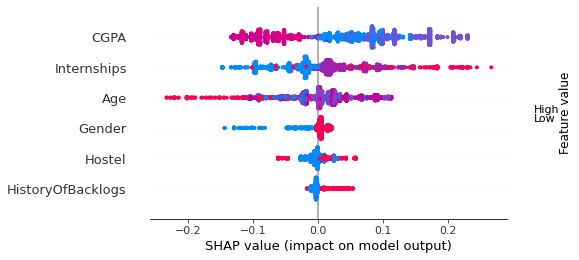

In [75]:
# plot shap values 
shap.summary_plot(shap_values_train['PlacedOrNot']['Stream_1'])

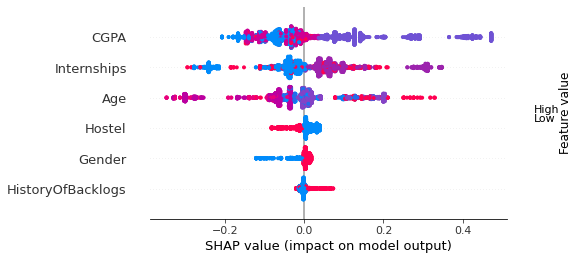

In [76]:
# plot shap values 
shap.summary_plot(shap_values_train['PlacedOrNot']['Stream_2'])

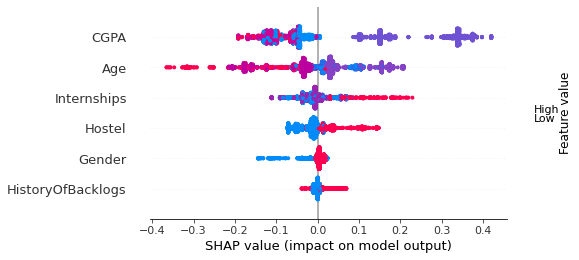

In [77]:
# plot shap values 
shap.summary_plot(shap_values_train['PlacedOrNot']['Stream_3'])

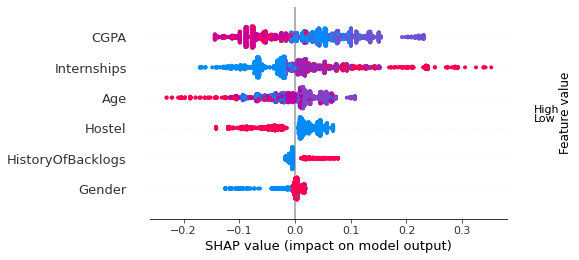

In [78]:
# plot shap values 
shap.summary_plot(shap_values_train['PlacedOrNot']['Stream_4'])

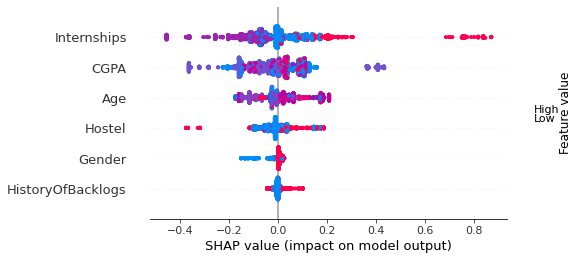

In [79]:
# plot shap values 
shap.summary_plot(shap_values_train['PlacedOrNot']['Stream_5'])

In [49]:
x_test_data = X_test.iloc[:1].copy()
x_test_data

,Age,Gender,Internships,CGPA,Hostel,HistoryOfBacklogs,Stream
2395,20,1,0,7,0,1,4


In [50]:
# calculate shap values of causal forest model on training data
shap_values_test_0 = est.shap_values(x_test_data)

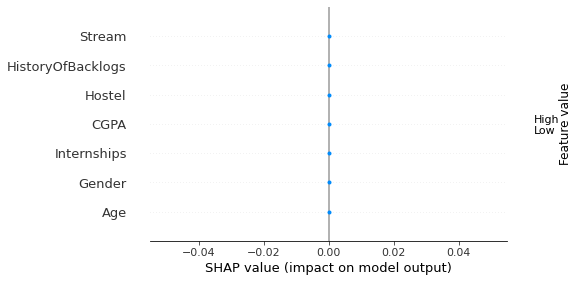

In [52]:
# plot shap values 
shap.summary_plot(shap_values_test_0['PlacedOrNot']['Stream_4'])

In [65]:
shap.initjs()
# explain the heterogeneity of the effect of any single sample
shap.force_plot(shap_values_test_0['PlacedOrNot']['Stream_4'][0])

In [21]:
# calculate shap values of causal forest model on training data
shap_values_test = est.shap_values(X_test)

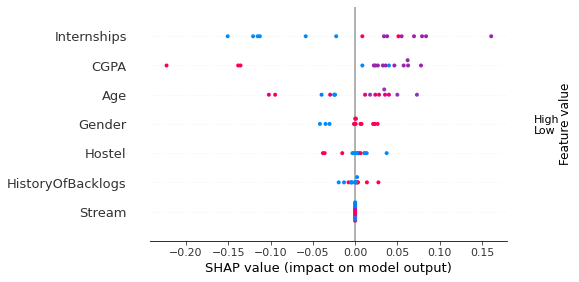

In [22]:
# plot shap values 
shap.summary_plot(shap_values_test['PlacedOrNot']['Stream_1'])

In [61]:
shap.initjs()
# explain the heterogeneity of the effect of any single sample
shap.force_plot(shap_values_test['PlacedOrNot']['Stream_1'][0])

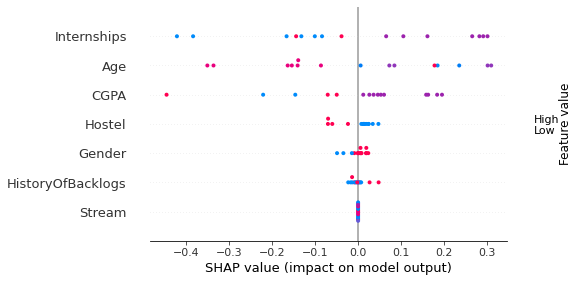

In [23]:
# plot shap values 
shap.summary_plot(shap_values_test['PlacedOrNot']['Stream_2'])

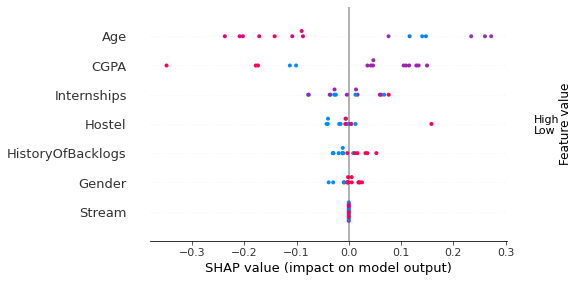

In [24]:
# plot shap values 
shap.summary_plot(shap_values_test['PlacedOrNot']['Stream_3'])

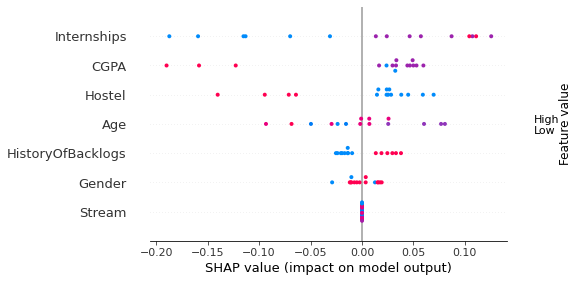

In [25]:
# plot shap values 
shap.summary_plot(shap_values_test['PlacedOrNot']['Stream_4'])

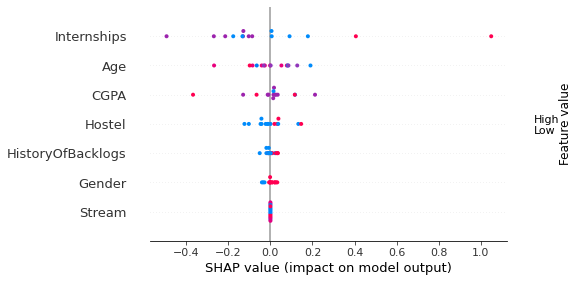

In [26]:
# plot shap values 
shap.summary_plot(shap_values_test['PlacedOrNot']['Stream_5'])

In [59]:
from econml.cate_interpreter import SingleTreeCateInterpreter

intrp = SingleTreeCateInterpreter(max_depth=5)
intrp.interpret(est, X_train_data)

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.


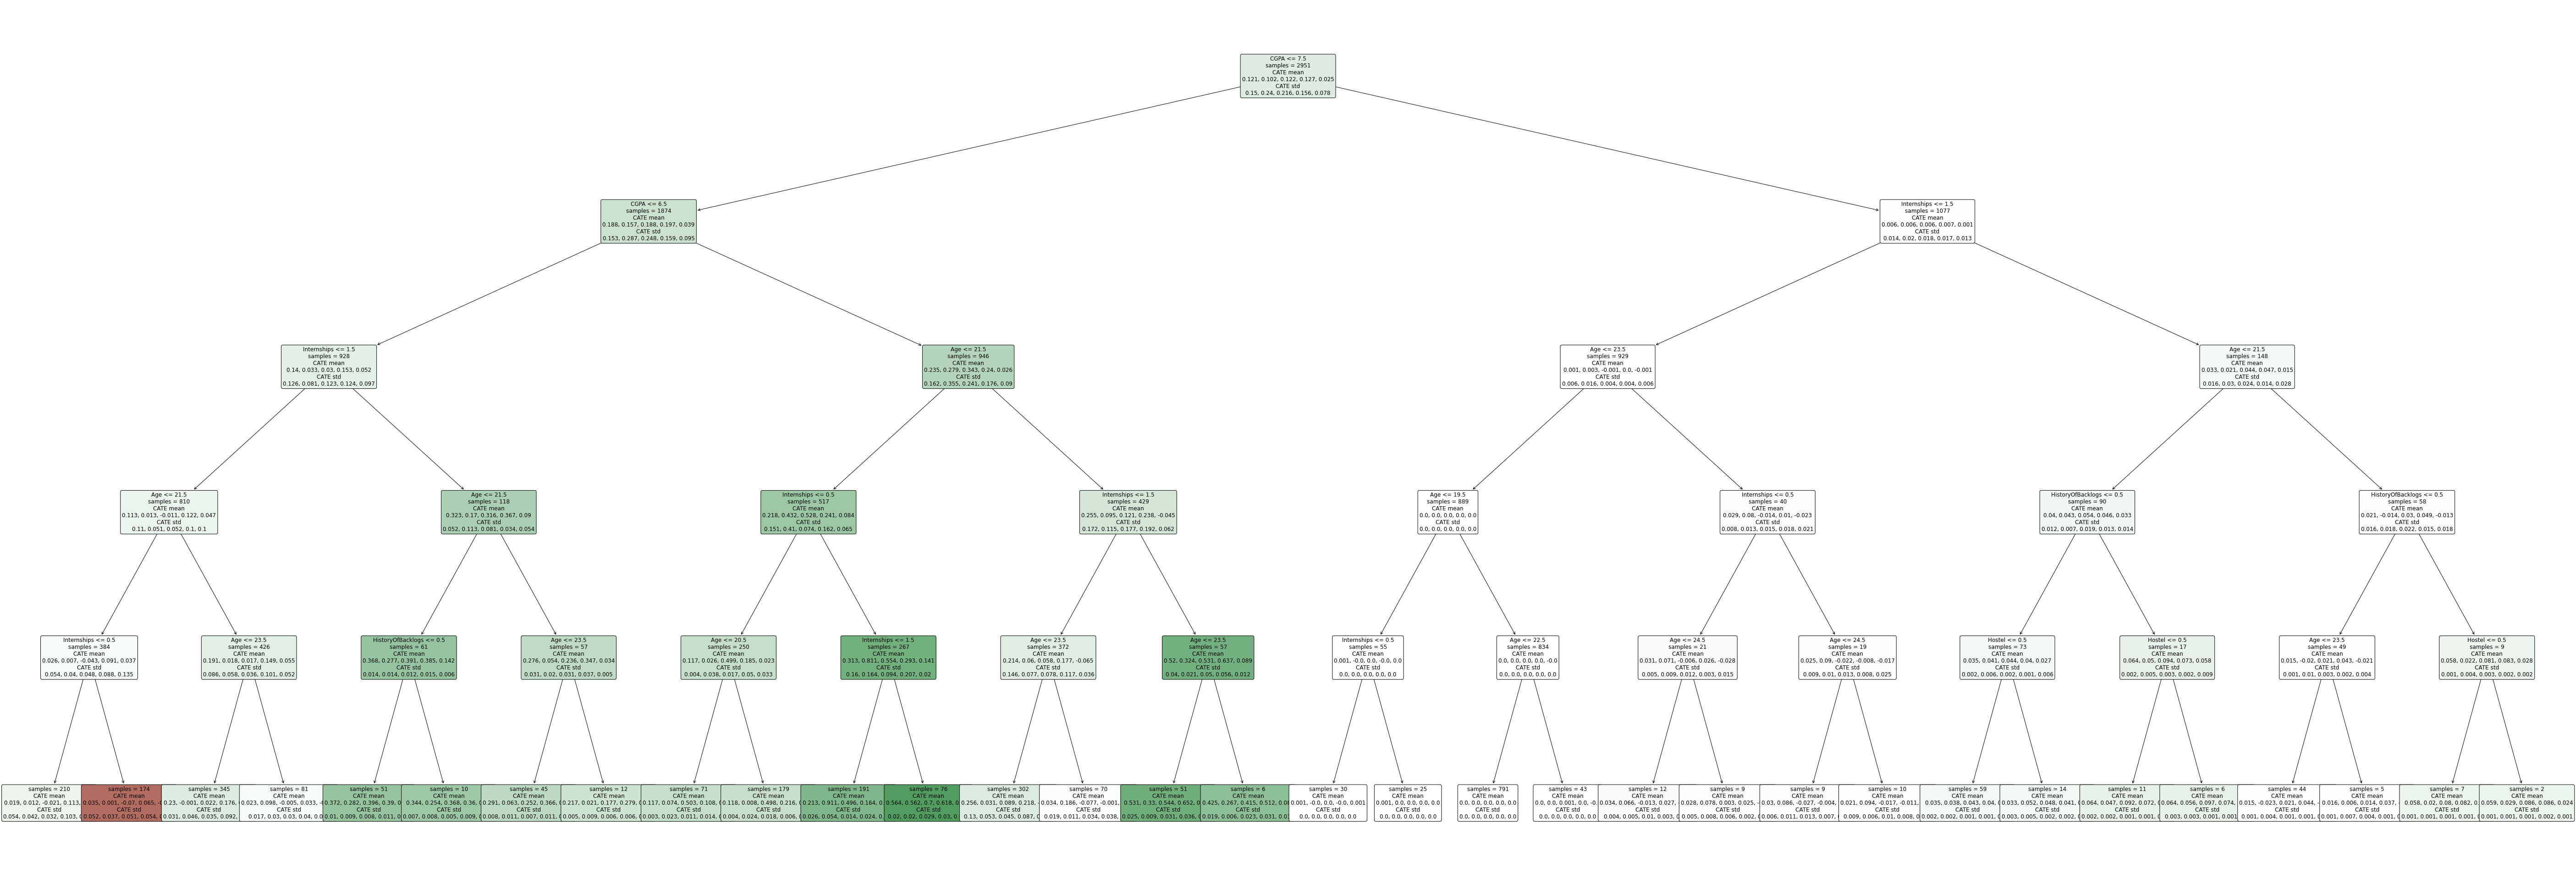

In [70]:
plt.figure(figsize=(100, 35))
intrp.plot(feature_names=X_train_data.columns, fontsize=12)